In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Exploratory Data Analysis 📌

In [2]:
# Directory for each class of Iris
setosa_dir = './archive/iris-setosa'
versicolour_dir = './archive/iris-versicolour'
virginica_dir = './archive/iris-virginica'

### Identifying Class Imbalance

Identifying class imbalance is our first step. We're going to visualize how many images are assigned to each class by creating a bar chart. By doing so, we can easily find the class imbalance, which could impact the model performance for the class with less representation.

In [3]:
# Dictionary to store class names and counts of images
number_classes = {
    'setosa': len(os.listdir(setosa_dir)),
    'versicolour': len(os.listdir(versicolour_dir)),
    'virginica': len(os.listdir(virginica_dir))
}

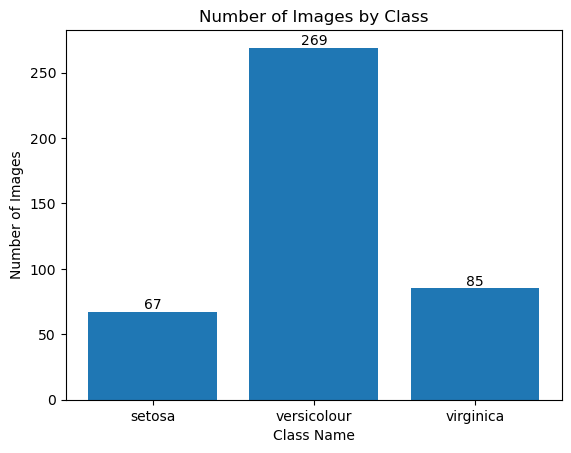

In [4]:
# Plot a bar chart for the count of images by Iris class
plt.bar(number_classes.keys(), number_classes.values())

for class_name, num_images in number_classes.items():
    plt.text(class_name, num_images, str(num_images), ha='center', va='bottom')

plt.title('Number of Images by Class')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.show()

### Plotting Image Size

Next, we're going to analyze the distribution of image sizes (height and width) within each class and visualize it using a scatter plot. It allows us to understand the variability in image dimensions within each class.

In [5]:
from PIL import Image
import dask.bag as bag
import random
import cv2
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [6]:
# Dictionary to store directory for each class
directories = {
    'setosa': setosa_dir+'/',
    'versicolour': versicolour_dir+'/',
    'virginica': virginica_dir+'/'
}

# Function to return dimensions for an RGB image (width, height)
def get_dims(file):
    with Image.open(file) as img:
        return img.size  

<Figure size 640x480 with 0 Axes>

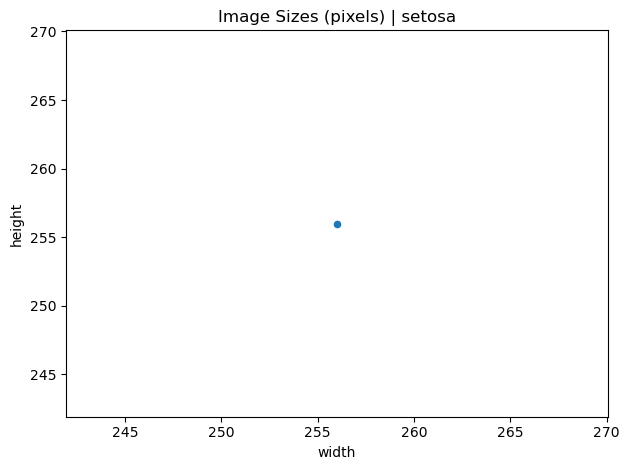

<Figure size 640x480 with 0 Axes>

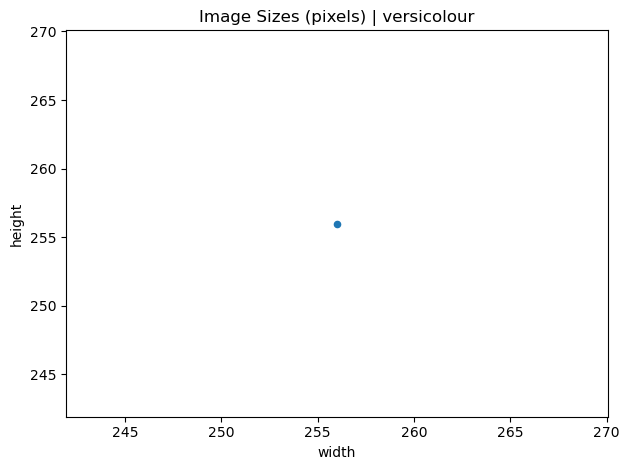

<Figure size 640x480 with 0 Axes>

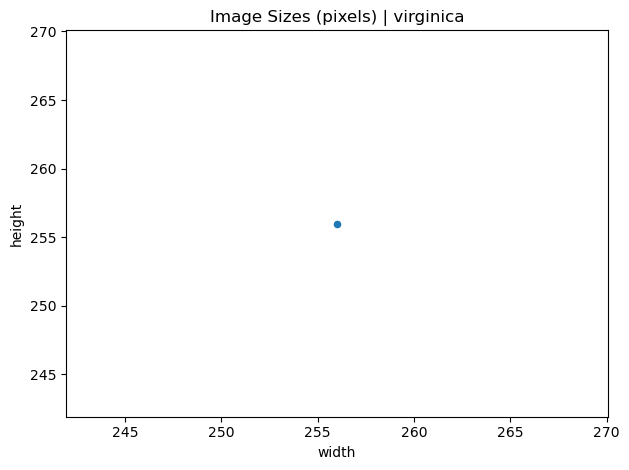

In [7]:
# Dictionary to store counts of dimensions for each class
class_dimensions_count = {}

# Iterate through folders in the dictionary and return dimensions of each image 
for n, d in directories.items():
    filepath = d
    filelist = [os.path.join(filepath, f) for f in os.listdir(filepath)]
    
    # Map the get_dims function to each file path
    dims = bag.from_sequence(filelist).map(get_dims)
    
    # Compute the dimensions in parallel
    dims = dims.compute()
    
    # Dictionary to store counts of dimensions for the current class
    dimensions_count = {}
    
    # Count occurences of each dimension
    for dim in dims:
        dimensions_count[dim] = dimensions_count.get(dim, 0) + 1
        
    # Store counts in the nested dictionary
    class_dimensions_count[n] = dimensions_count
    
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    
    # Group dimensions by height and width and count occurrences
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0: 'count'})
    
    # Plot a scatter plot of image sizes
    plt.figure()
    sizes.plot.scatter(x='width', y='height')
    plt.title('Image Sizes (pixels) | {}'.format(n))
    plt.tight_layout() 
    plt.show()  

In [8]:
# Print dictionary of counts of dimensions for each class
print(class_dimensions_count)

{'setosa': {(256, 256): 67}, 'versicolour': {(256, 256): 269}, 'virginica': {(256, 256): 85}}


The result indicates that all classes have a consistent image dimension of 256 x 256.

### Plotting Image Brightness

We are also interested in analyzing the brightness distribution within each class.

In [9]:
# Function to return percentage of brightness in an image
def calculate_brightness(image_path):
    '''
    Load an image from the specified file path.
    Convert the color space of the image from BGR to HSV.
    Calculate the average brightness of the pixels in the Value channel.
    Return the percentage of brightness.
    '''
    img = cv2.imread(image_path) 
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    avg = np.mean(hsv[:,:,2])
    per = (avg/255)*100
    return per

In [10]:
# Dictionary to store counts of brightness for each class
class_brightness_count = {}

for n, d in directories.items():
    filepath = d
    filelist = [os.path.join(filepath, f) for f in os.listdir(filepath)]
    
    # List to store brightness for each class
    brightness = []
    
    for file_path in filelist:
        brightness.append(calculate_brightness(file_path))
        
        # Dictionary to store counts of brightness for the current class
        brightness_count = {}

         # Count occurences of each brightness
        for bri in brightness:
            brightness_count[bri] = brightness_count.get(bri, 0) + 1

        # Store counts in the nested dictionary
        class_brightness_count[n] = brightness_count

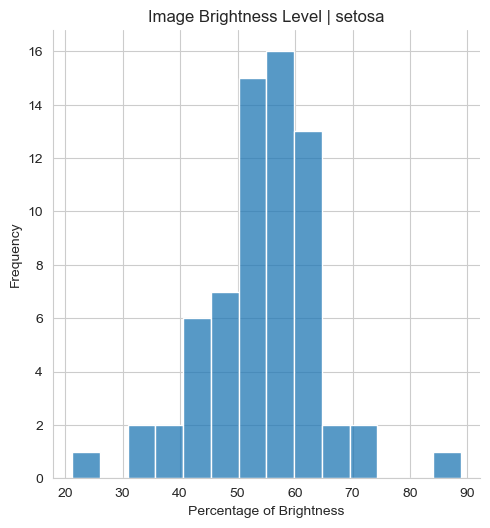

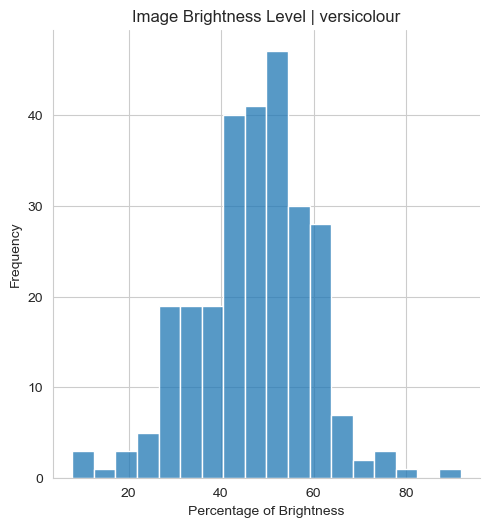

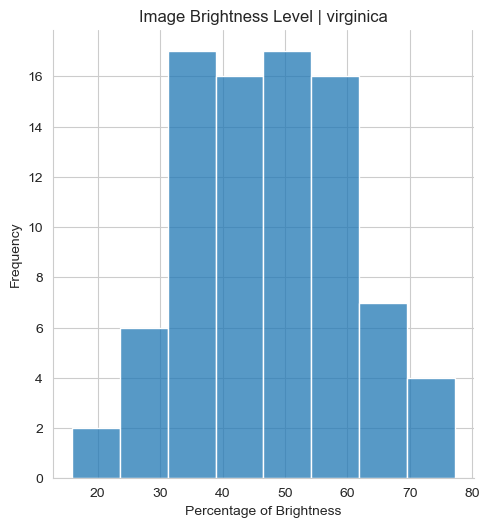

In [11]:
brightness_df = pd.DataFrame(class_brightness_count)

# Display the brightness distribution for each class
for class_name, brightness_count in class_brightness_count.items():
    sns.set_style('whitegrid')
    sns.displot(list(brightness_count.keys()), kde=False)
    plt.title(f'Image Brightness Level | {class_name}')
    plt.xlabel('Percentage of Brightness')
    plt.ylabel('Frequency')
    plt.show()

Image brightness levels for three classes are distributed similarly in an approximate bell shape.

### Displaying Images by Class

We will then look at a random image from each class and get ourselves familiarize with the dataset. 

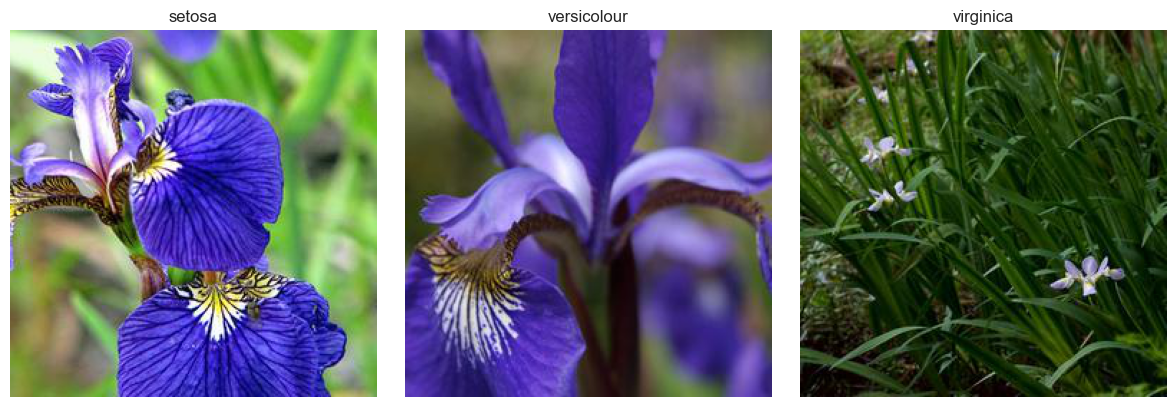

In [12]:
# Function to display a random image from a directory
def display_random_image(directory, ax, title):
    filelist = [os.path.join(directory, f) for f in os.listdir(directory)]
    random_image_path = random.choice(filelist)
    with Image.open(random_image_path) as img:
        ax.imshow(img)
        ax.axis('off')  
        ax.set_title(title)
        
# Display a random image from each class
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))

for i, (class_name, directory) in enumerate(directories.items()):
    display_random_image(directory, ax[i], class_name)

plt.tight_layout()
plt.show()

## Data Preprocessing & Feature Engineering 🚀

We will perform feature engineering by augmenting data through a number of random transformations. This helps reduce overfitting and improve model's generalization capabilities to unseen data. We will also standardize data to ensure each input feature has the same distribution.

### Splitting Training and Test Sets

Before data augmentation, we will split the dataset into training and test sets. This ensures that the distribution of classes remains consistent between the training and test sets.

In [13]:
import shutil
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import keras

In [14]:
# Directories containing images for each class
class_folders = [setosa_dir, versicolour_dir, virginica_dir]
path = './archive/'
train_dir = os.path.join(path, 'train_data')
test_dir = os.path.join(path, 'test_data')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [15]:
# Define the train-test split ratio (80% train, 20% test)
split_ratio = 0.8

for class_folder in class_folders:
    images = os.listdir(class_folder)
    random.shuffle(images)
    
    # Create train and test directories for the class
    train_class_dir = os.path.join(train_dir, os.path.basename(class_folder))
    test_class_dir = os.path.join(test_dir, os.path.basename(class_folder))
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)
    
    # Calculate the number of images for train and test sets
    num_train = int(len(images) * split_ratio)
    
    # Split images into train and test sets
    train_images = images[:num_train]
    test_images = images[num_train:]
    
    # Move train images to train directory
    for image in train_images:
        source = os.path.join(class_folder, image)
        dest = os.path.join(train_class_dir, image)
        shutil.copy(source, dest)
        
    # Move test images to test directory
    for image in test_images:
        source = os.path.join(class_folder, image)
        dest = os.path.join(test_class_dir, image)
        shutil.copy(source, dest)

In [16]:
# Print number of images in training and test sets
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    print(f'Training set: {class_folder}: {len(os.listdir(class_path))}')
    
for class_folder in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_folder)
    print(f'Test set: {class_folder}: {len(os.listdir(class_path))}')

Training set: iris-setosa: 53
Training set: iris-versicolour: 215
Training set: iris-virginica: 68
Test set: iris-setosa: 14
Test set: iris-versicolour: 54
Test set: iris-virginica: 17


### Creating lables & Loading the data

In [17]:
# Definie parameter for loading data
batch_size = 10
image_size = (224, 224) 

# Load the training data
train_ds = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    image_size=image_size,
    validation_split=0.2,
    subset='training',
    seed=42
)

# Load the validation data
valid_ds = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    image_size=image_size,
    validation_split=0.2,
    subset='validation',
    seed=42
)

Found 336 files belonging to 3 classes.
Using 269 files for training.
Found 336 files belonging to 3 classes.
Using 67 files for validation.


In [18]:
# Load the test data
test_ds = keras.utils.image_dataset_from_directory(
    directory=test_dir,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=False
)

Found 85 files belonging to 3 classes.


### Data Augmentation

Data augmentation increases the diversity of your training dataset by applying random transformations. This helps improve the model's robustness and generalization.

In [19]:
from keras import layers
import keras

In [20]:
# Define data augmentation layers
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

# Apply data augmentation to the training set
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

### Standardizing Data

Standardized data ensures that the data is on a comparable scale, which can significantly impact the performance and training efficiency of the model. It helps the optimization algorithm to converge faster during training. 

In [21]:
# Define standardization layer
normalization_layer = layers.Rescaling(1./255)

# Apply standardization layer to the data
train_ds = train_ds.map(lambda image, label: (normalization_layer(image), label))
valid_ds = valid_ds.map(lambda image, label: (normalization_layer(image), label))
test_ds = test_ds.map(lambda image, label: (normalization_layer(image), label))

## Proposed Approaches (Model) 💡

###  Approach 1: Convolutional Neural Networks (CNNs)

We're going to design the CNN architecture by adding layers to learn spatial hierarchies of features and train the model.

In [31]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from sklearn.metrics import accuracy_score, classification_report

In [23]:
# Count the number of classes
class_folders = os.listdir(train_dir)
num_classes = len(class_folders)

# Define the model
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')  
])

In [24]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)      

In [25]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10 
)

Epoch 1/10
27/27 [==============================] - 24s 738ms/step - loss: 1.1559 - accuracy: 0.6171 - val_loss: 1.0041 - val_accuracy: 0.6418
Epoch 2/10
27/27 [==============================] - 20s 717ms/step - loss: 0.9420 - accuracy: 0.6394 - val_loss: 0.8888 - val_accuracy: 0.6418
Epoch 3/10
27/27 [==============================] - 19s 697ms/step - loss: 0.9156 - accuracy: 0.6394 - val_loss: 0.8822 - val_accuracy: 0.6418
Epoch 4/10
27/27 [==============================] - 19s 704ms/step - loss: 0.9025 - accuracy: 0.6394 - val_loss: 0.8708 - val_accuracy: 0.6418
Epoch 5/10
27/27 [==============================] - 20s 719ms/step - loss: 0.8901 - accuracy: 0.6394 - val_loss: 0.8806 - val_accuracy: 0.6418
Epoch 6/10
27/27 [==============================] - 20s 723ms/step - loss: 0.9019 - accuracy: 0.6394 - val_loss: 0.9665 - val_accuracy: 0.6418
Epoch 7/10
27/27 [==============================] - 19s 703ms/step - loss: 0.9239 - accuracy: 0.6394 - val_loss: 0.8872 - val_accuracy: 0.6418

Let's visuliaze a few prediction results by comparing their predicted and actual labels.

1/1 [==============================] - 0s 468ms/step


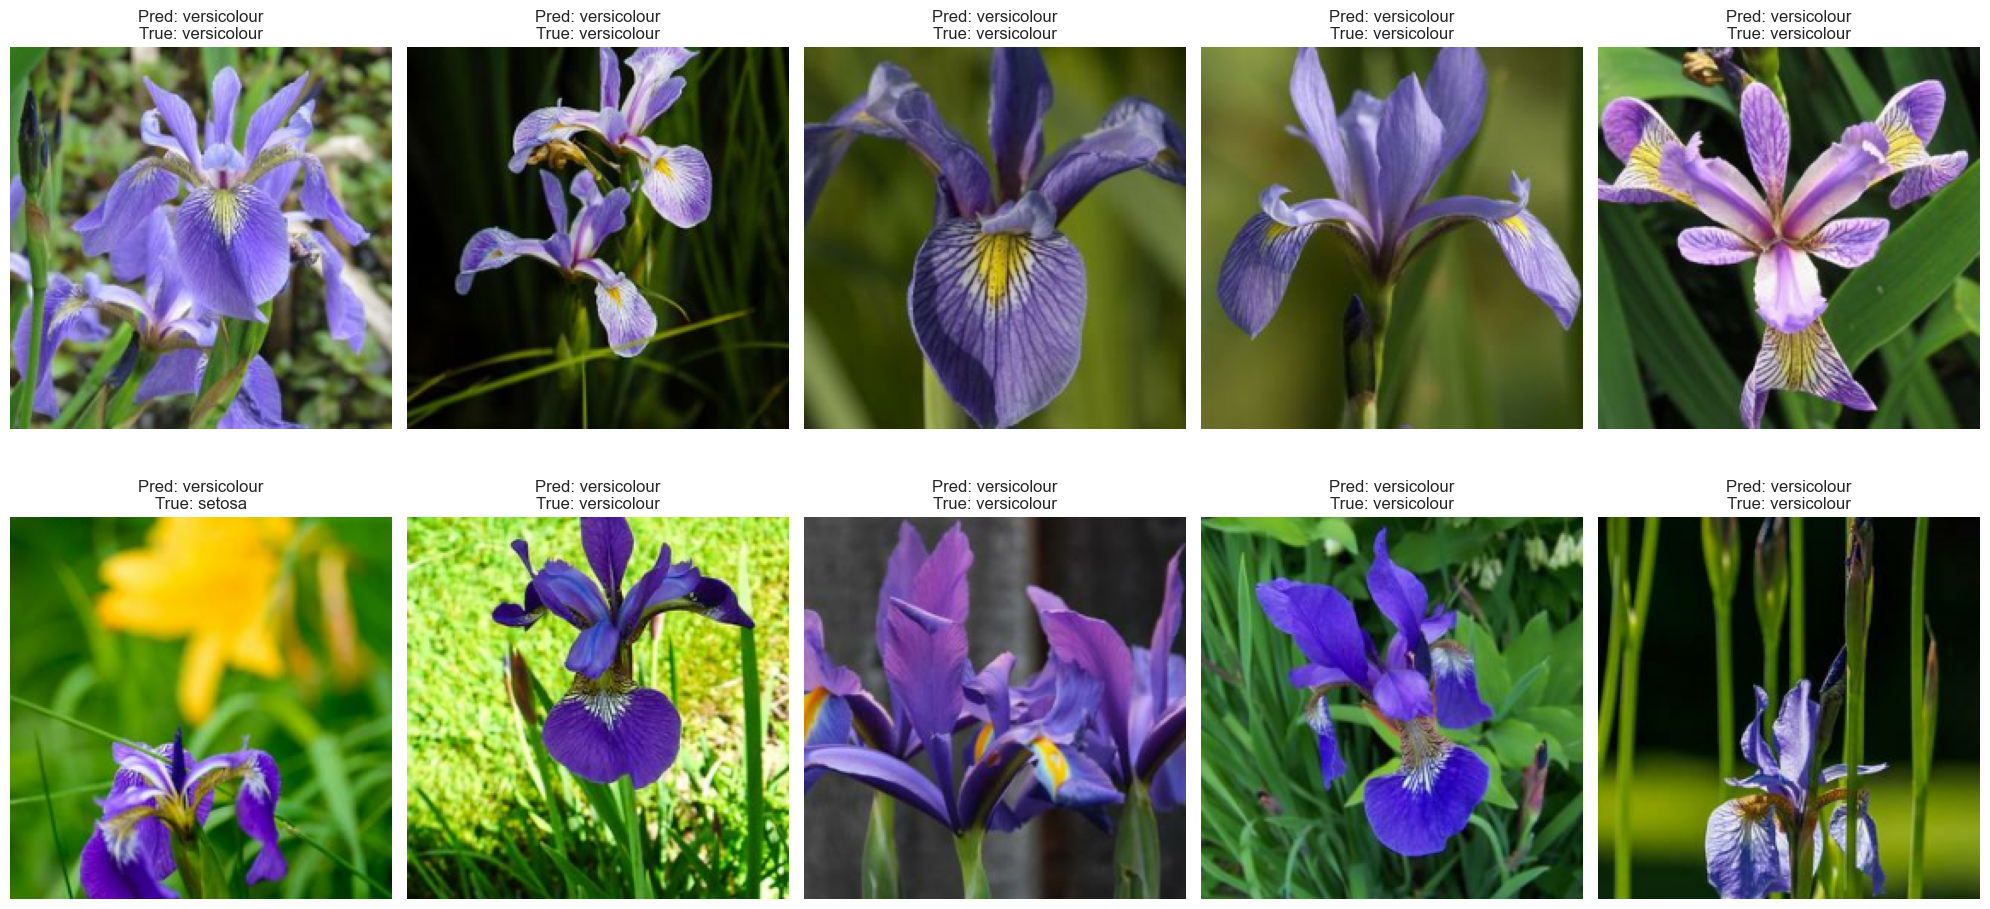

In [26]:
class_names = ['setosa', 'versicolour', 'virginica']

plt.figure(figsize=(20, 10))
for images, labels in valid_ds.take(1):
    # Make predictions
    predictions = model.predict(images)
    
    # Convert predictions to class names
    pred_labels = [class_names[np.argmax(pred)] for pred in predictions]
    true_labels = [class_names[label] for label in labels]
    
    # Plot the first 10 images with their predictions and actual labels
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        img = images[i].numpy() * 255 # Rescale back to [0, 255]
        img = img.astype('uint8')
        plt.imshow(img)
        plt.title(f'Pred: {pred_labels[i]}\nTrue: {true_labels[i]}')
        plt.axis('off')

plt.tight_layout()
plt.show()

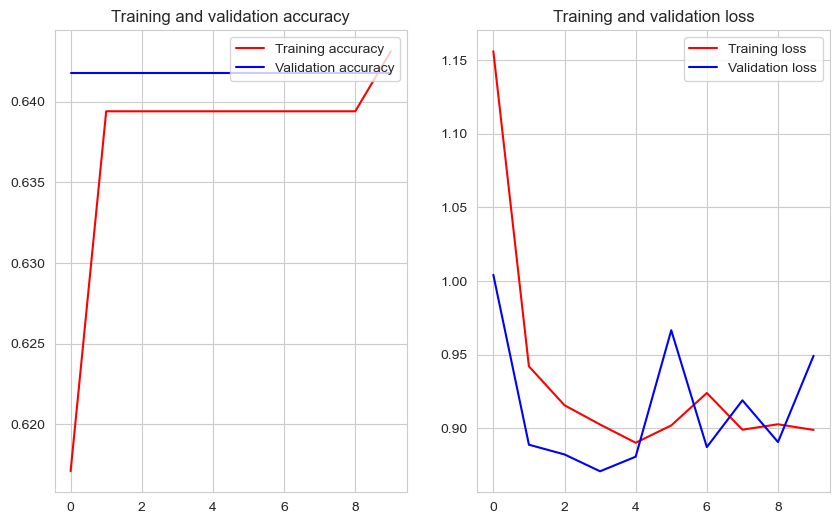

In [27]:
# Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='upper right') 

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='upper right') 

plt.show()

In [28]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_ds)

# Print the accuracy
print(f'Test Accuracy: {accuracy}')
print(f'Test Loss: {loss}')

9/9 [==============================] - 2s 167ms/step - loss: 0.8981 - accuracy: 0.6353
Test Accuracy: 0.6352941393852234
Test Loss: 0.8980991244316101


In [29]:
from tensorflow.keras.models import load_model

# Save model to a file
model.save('my_model.keras')

# Load the saved model
my_model = load_model('my_model.keras')

# Extract true labels and predictions
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    # Make predictions
    predictions = my_model.predict(images)
    
    # Convert predictions to class names
    pred_labels = [class_names[np.argmax(pred)] for pred in predictions]
    true_labels_batch = [class_names[label] for label in labels.numpy()]

    # Extend the lists with the current batch results
    predicted_labels.extend(pred_labels)
    true_labels.extend(true_labels_batch)

1/1 [==============================] - 0s 128ms/step


In [32]:
# Use the classification report to evaluate the model
print(classification_report(true_labels, predicted_labels, target_names=class_names))

              precision    recall  f1-score   support

      setosa       0.00      0.00      0.00        14
 versicolour       0.64      1.00      0.78        54
   virginica       0.00      0.00      0.00        17

    accuracy                           0.64        85
   macro avg       0.21      0.33      0.26        85
weighted avg       0.40      0.64      0.49        85



### Model Evaluation

**Imbalanced Performance:** 
- The model is performing well only for the versicolour class. This indicates a strong class imbalance or the model is biased towards the versicolour class.

**Poor Identification of Setosa and Virginica:** 
- The model fails to identify setosa and virginica correctly. It could be due to insufficient data for these classes, class imbalance, or the features not being distinctive enough.

### Approach 2: Transfer Learning with EfficientNetB0

We're going to instantiate a base model and load pre-trained weights into it. New layers are added on top of the base model. After that, we will freeze the base model layers to train only the new top layers.

In [33]:
# Instantiate a base model with pre-trained weights
base_model = keras.applications.EfficientNetB0(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
    
# Add top layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the full model
xcep_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False
    
# Compile the model
xcep_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
# Train the model
history_tl = xcep_model.fit(train_ds, validation_data=valid_ds, epochs=10)

Epoch 1/10
27/27 [==============================] - 40s 906ms/step - loss: 0.9501 - accuracy: 0.6245 - val_loss: 0.9394 - val_accuracy: 0.6418
Epoch 2/10
27/27 [==============================] - 20s 724ms/step - loss: 0.9451 - accuracy: 0.6431 - val_loss: 0.9134 - val_accuracy: 0.6418
Epoch 3/10
27/27 [==============================] - 21s 773ms/step - loss: 0.9238 - accuracy: 0.6394 - val_loss: 0.9020 - val_accuracy: 0.6418
Epoch 4/10
27/27 [==============================] - 21s 779ms/step - loss: 0.9212 - accuracy: 0.6394 - val_loss: 0.9108 - val_accuracy: 0.6418
Epoch 5/10
27/27 [==============================] - 20s 746ms/step - loss: 0.9451 - accuracy: 0.6394 - val_loss: 0.9081 - val_accuracy: 0.6418
Epoch 6/10
27/27 [==============================] - 20s 741ms/step - loss: 0.9380 - accuracy: 0.6394 - val_loss: 0.8961 - val_accuracy: 0.6418
Epoch 7/10
27/27 [==============================] - 21s 754ms/step - loss: 0.9244 - accuracy: 0.6394 - val_loss: 0.9012 - val_accuracy: 0.6418

Let's visuliaze a few prediction results by comparing their predicted and actual labels.

1/1 [==============================] - 5s 5s/step


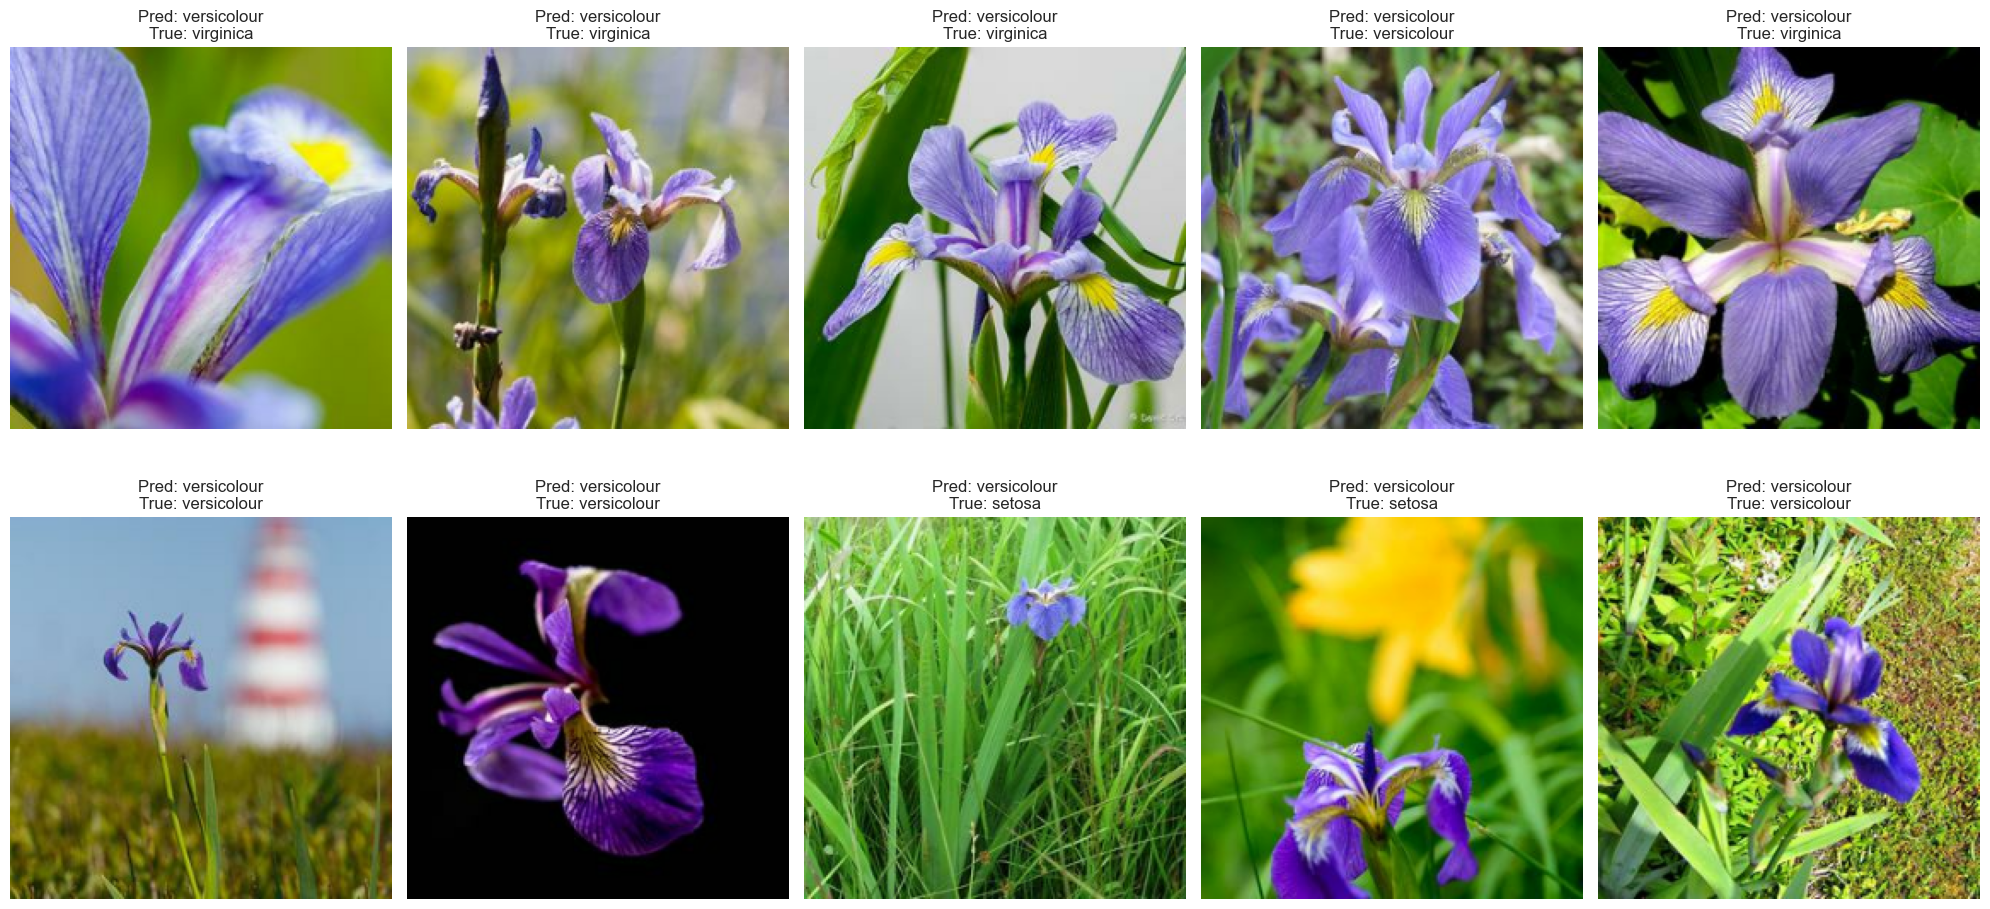

In [35]:
plt.figure(figsize=(20, 10))

for images, labels in valid_ds.take(1):
 
    predictions = xcep_model.predict(images)
    
    # Convert predictions to class names
    pred_labels = [class_names[np.argmax(pred)] for pred in predictions]
    true_labels = [class_names[label] for label in labels]
    
    # Plot the first 10 images with their predictions and actual labels
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        img = images[i].numpy() * 255 # Rescale back to [0, 255]
        img = img.astype('uint8')
        plt.imshow(img)
        plt.title(f'Pred: {pred_labels[i]}\nTrue: {true_labels[i]}')
        plt.axis('off')

plt.tight_layout()
plt.show()

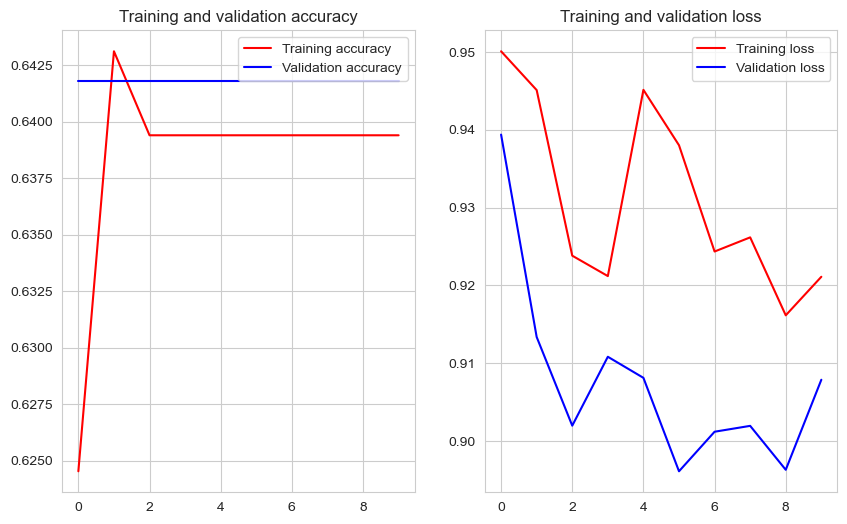

In [36]:
# Plot training and validation accuracy and loss
acc = history_tl.history['accuracy']
val_acc = history_tl.history['val_accuracy']
loss = history_tl.history['loss']
val_loss = history_tl.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='upper right') 

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='upper right') 


In [37]:
# Evaluate the model on the test set
loss, accuracy = xcep_model.evaluate(test_ds)

# Print the accuracy
print(f'Test Accuracy: {accuracy}')
print(f'Test Loss: {loss}')

9/9 [==============================] - 5s 589ms/step - loss: 0.9196 - accuracy: 0.6353
Test Accuracy: 0.6352941393852234
Test Loss: 0.9195723533630371


In [38]:
# Save model to a file
xcep_model.save('xcep_model.keras')

# Load the saved model
xcep_model = load_model('xcep_model.keras')

# Extract true labels and predictions
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    # Make predictions
    predictions = xcep_model.predict(images)
    
    # Convert predictions to class names
    pred_labels = [class_names[np.argmax(pred)] for pred in predictions]
    true_labels_batch = [class_names[label] for label in labels.numpy()]

    # Extend the lists with the current batch results
    predicted_labels.extend(pred_labels)
    true_labels.extend(true_labels_batch)

1/1 [==============================] - 0s 336ms/step


In [39]:
# Use the classification report to evaluate the model
print(classification_report(true_labels, predicted_labels, target_names=class_names))

              precision    recall  f1-score   support

      setosa       0.00      0.00      0.00        14
 versicolour       0.64      1.00      0.78        54
   virginica       0.00      0.00      0.00        17

    accuracy                           0.64        85
   macro avg       0.21      0.33      0.26        85
weighted avg       0.40      0.64      0.49        85



### Model Evaluation

**Training vs. Validation Performance:**

 - The training accuracy (63.20%) and validation accuracy (64.18%) are somewhat close, indicating that the model is not severely overfitting.
 - The test accuarcy (63.53%) is closed to the training and validation accuracy, suggsting the model is not overfitting and generalizing well to the unseen data.
- However, the accuracy values (around 63-64%) suggest that the model might not be performing exceptionally well overall. 
 
**Loss Values:**
- Both training and validation loss values are relatively high, indicating that the model's predictions are not very confident or accurate.
- However, the difference between training and validation loss is minimal, suggesting that the model is not significantly overfitting to the training data.

### Approach 3: SVM with Pre-trained VGG16

We're going to extract features from images using the pre-trained VGG16 model and train an SVM classifier using these features. The images will be read and resized to a fixed size of 224 x 224 pixels, and flattened to a 1D array. 

In [40]:
from keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.svm import SVC

In [41]:
# Initialize the VGG16 model for feature extraction
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Function to extract features from an image file
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = base_model.predict(x)
    return features.flatten()

In [42]:
# Function to load and extract features from a directory
def load_data_and_extract_features(directory):
    X = []
    y = []
    for label, class_dir in enumerate(os.listdir(directory)):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                features = extract_features(img_path)
                X.append(features)
                y.append(label)
    return np.array(X), np.array(y)

In [43]:
# Load and extract features from the training and test sets
X_train, y_train = load_data_and_extract_features(train_dir)
X_test, y_test = load_data_and_extract_features(test_dir)

1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 150ms/step


We will standardize the array data before training an SVM classifier.

In [44]:
from sklearn.preprocessing import StandardScaler

# Standardize the input data
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
# Train the SVM model
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train_scaled, y_train)

# Evaluate the model using the test data 
y_pred = svm_rbf.predict(X_test_scaled) 
  
# Calculate the accuracy of the model 
accuracy = accuracy_score(y_pred, y_test) 
  
# Print the accuracy of the model 
print(f'Test Accurary: {accuracy}')

Test Accurary: 0.6352941176470588


In [46]:
# # Use the classification report to evaluate the model
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      setosa       0.00      0.00      0.00        14
 versicolour       0.64      1.00      0.78        54
   virginica       0.00      0.00      0.00        17

    accuracy                           0.64        85
   macro avg       0.21      0.33      0.26        85
weighted avg       0.40      0.64      0.49        85



### Model Evaluation

**Accuracy** 
- The overall accuracy of the model is 64%. 

**Imbalanced Performance**
- The model performs well for the versicolor class but fails completely for setosa and virginica. It could be due to the class imbalance, with versicoulor having the most instances, which can affect the performance metrics.

## Proposed Solution (Model Selection) 📝

I will choose approach 1 (CNN model) as the final model. By reviewing the performance metrics for each approach, we observe similar performance behaviors across the models: they perform relatively well for the versicolour class but poorly for the other two classes (setosa and virginica). Given that no particular model provides a significantly better result, I will opt for the CNN model because it takes less storage to run and is more flexible to improve generalization and performance aross all classes.

## How the model can be improved 🧰

**Address Class Imbalance**
- Use techniques like oversampling, undersampling, or class weighting to balance the classes

**Data Augmentation**
- Apply data augmentation techniques to artificially increase the size of the training dataset, which can help the model generalize better

**Regularization**
- Add regularization techniques such as dropout, L1/L2 regularization to prevent overfitting and improve generalization

**Hyperparameter Tuning**
- Adjust learning rate, batch size, number of epochs, and other hyperparameters. Use techniques like random search to find optimal hyperparameters.